# Airbnb Analysis


In [1]:
!pip install scikit-learn
!pip install pandas
!pip install seaborn
!pip install matplotlib.pyplot
!pip install geopandas
!pip install numpy
!pip install altair
!pip install doctest
!pip install -q folium mapclassify

ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot
ERROR: Could not find a version that satisfies the requirement doctest (from versions: none)
ERROR: No matching distribution found for doctest
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 5.0 MB/s eta 0:00:00


In [2]:
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import altair as alt
import doctest
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
sns.set_theme()

In [3]:
# load in listings as a csv and gdf, change price to float, load in map as a geojson
listing_path = "listings.csv"
map_path = "neighbourhoods.geojson"
listings_test = pd.read_csv("listings-small.csv").set_index("id")
listings = pd.read_csv(listing_path).set_index("id")
listing_gdf = gpd.GeoDataFrame(
    listings,
    # crs="EPSG:4326" specifies WGS84 or GPS coordinate system, see https://epsg.io/4326
    geometry=gpd.points_from_xy(listings["longitude"], listings["latitude"], crs="EPSG:4326")
)
listings["price"] = listings["price"].replace("[\\$,]", "", regex=True).astype(float)
gjsn = gpd.read_file(map_path)

assert listing_path.endswith('.csv'), "listings must be a csv"
assert map_path.endswith('.geojson'), "listings must be a geojson"

# Results


In [4]:
# 1. Which neighborhoods in Seattle are the most popular for Airbnbs?
"""
explore an interactive map of all listings in Seattle
"""
listing_gdf.explore(column="neighbourhood_group_cleansed")

"""
plots a bar chart with each neighborhood in Seattle (x-axis) and the number of Airbnbs as the y-axis
Made interactive using altair due to large num of neighbourhoods.
"""
neighbourhood_counts = listings.groupby("neighbourhood_cleansed").size().reset_index(name="count")

num_chart = alt.Chart(neighbourhood_counts).mark_bar().encode(
    x=alt.X("neighbourhood_cleansed:N", title="Neighbourhood"),
    y=alt.Y("count:Q", title="Number of Listings"),
    tooltip=["neighbourhood_cleansed", "count"]
).properties(
    width=800,
    height=400,
    title="Number of Airbnb Listings by Neighbourhood"
).interactive()

num_chart.display()


"""
plots a bar chart with each neighborhood in Seattle (x-axis) and the average rating of Airbnbs as the y-axis.
Made interactive using altair
"""
listing_df_clean = listings.dropna(subset=["review_scores_rating"])
neighbourhood_stats = listing_df_clean.groupby("neighbourhood_cleansed")["review_scores_rating"].agg(["mean", "count"])
neighbourhood_stats = neighbourhood_stats[neighbourhood_stats["count"] > 0]
neighbourhood_stats["mean"] = neighbourhood_stats["mean"].round(2)
mean_rating = neighbourhood_stats["mean"].to_dict()

neighbourhood_stats_altair = neighbourhood_stats.reset_index()

rating_chart = alt.Chart(neighbourhood_stats_altair).mark_bar().encode(
    x="neighbourhood_cleansed:N",
    y="mean:Q",
    tooltip=["neighbourhood_cleansed", "mean"]
).properties(
    width=800,
    height=400,
    title="Mean Ratings by Neighbourhood"
).interactive()

rating_chart.display()

unique = listings.neighbourhood_cleansed.unique()
assert len(unique) == 88, "Number of neighbourhoods does not match"

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

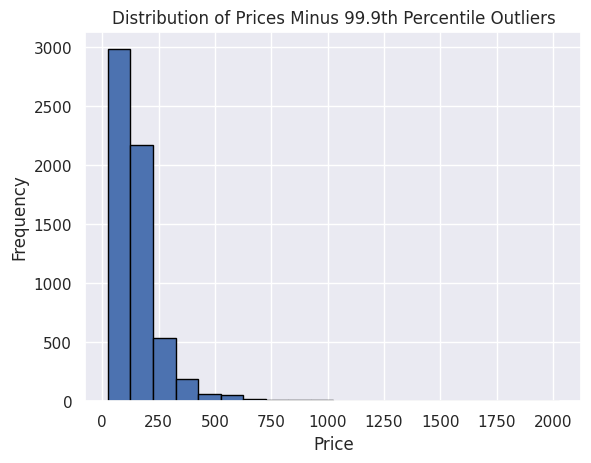

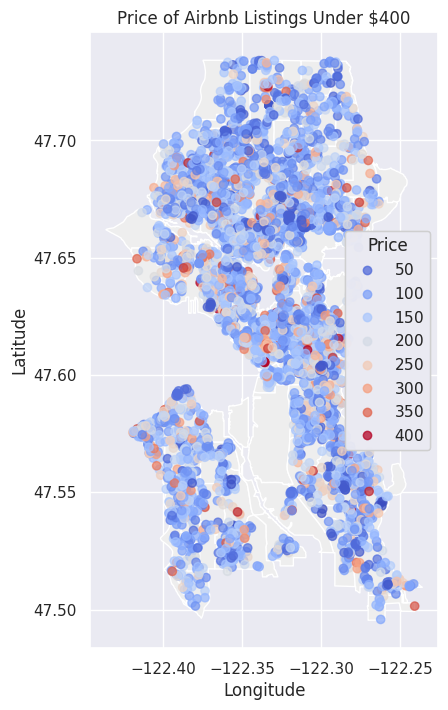

In [5]:
# 2. Which neighborhoods in Seattle contain the most expensive Airbnbs?
# What does the price distribution of Airbnbs look like?
"""
Maps a histogram of prices
"""
listings_filtered = listings[listings["price"] <= 2100]

plt.hist(listings_filtered["price"], bins=20, edgecolor="black")

# Add labels and title
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.title("Distribution of Prices Minus 99.9th Percentile Outliers")
# ax.set_ylim(ymax=2000)

plt.show()


"""
Creates a scatterplot representing a map of Seattle and the average price
of Airbnbs (red = more expensive, blue = cheaper)
"""
# the price threshold can be changed. I found that including listings above this made it difficult to
# distinguish different prices on the map, because the majority of them are <= $400.
price_threshold = 400

listings_filtered = listings[listings["price"] <= price_threshold]

latitude = listings_filtered["latitude"]
longitude = listings_filtered["longitude"]
price = listings_filtered["price"]

fig, ax = plt.subplots(figsize=(10, 8))
gjsn.plot(ax=ax, color="#EEE")

sc = ax.scatter(longitude, latitude, c=price, cmap="coolwarm", alpha=0.7)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Price of Airbnb Listings Under $" + str(price_threshold))

# USED AI IN LINE 23: prompt: what is *sc matplotlib
legend1 = ax.legend(*sc.legend_elements(), title="Price")
ax.add_artist(legend1)

plt.show()

assert ax.get_xlabel() == "Longitude", "x-label must be longitude"
assert ax.get_ylabel() == "Latitude", "y-label must be latitude"
for i in listings_filtered["price"]:
    assert i <= int(price_threshold), "all prices included must be <= threshold"
    assert i > 0, "all prices must be greater than 0"

Accuracy of Model: 0.7388535031847133
price 0.6779987590521438
accommodates 0.08493521762923933
review_scores_rating 0.1974232704526128
host_response_rate 0.03964275286600395
Mean Squared Error: 0.2611464968152866


0.2611464968152866

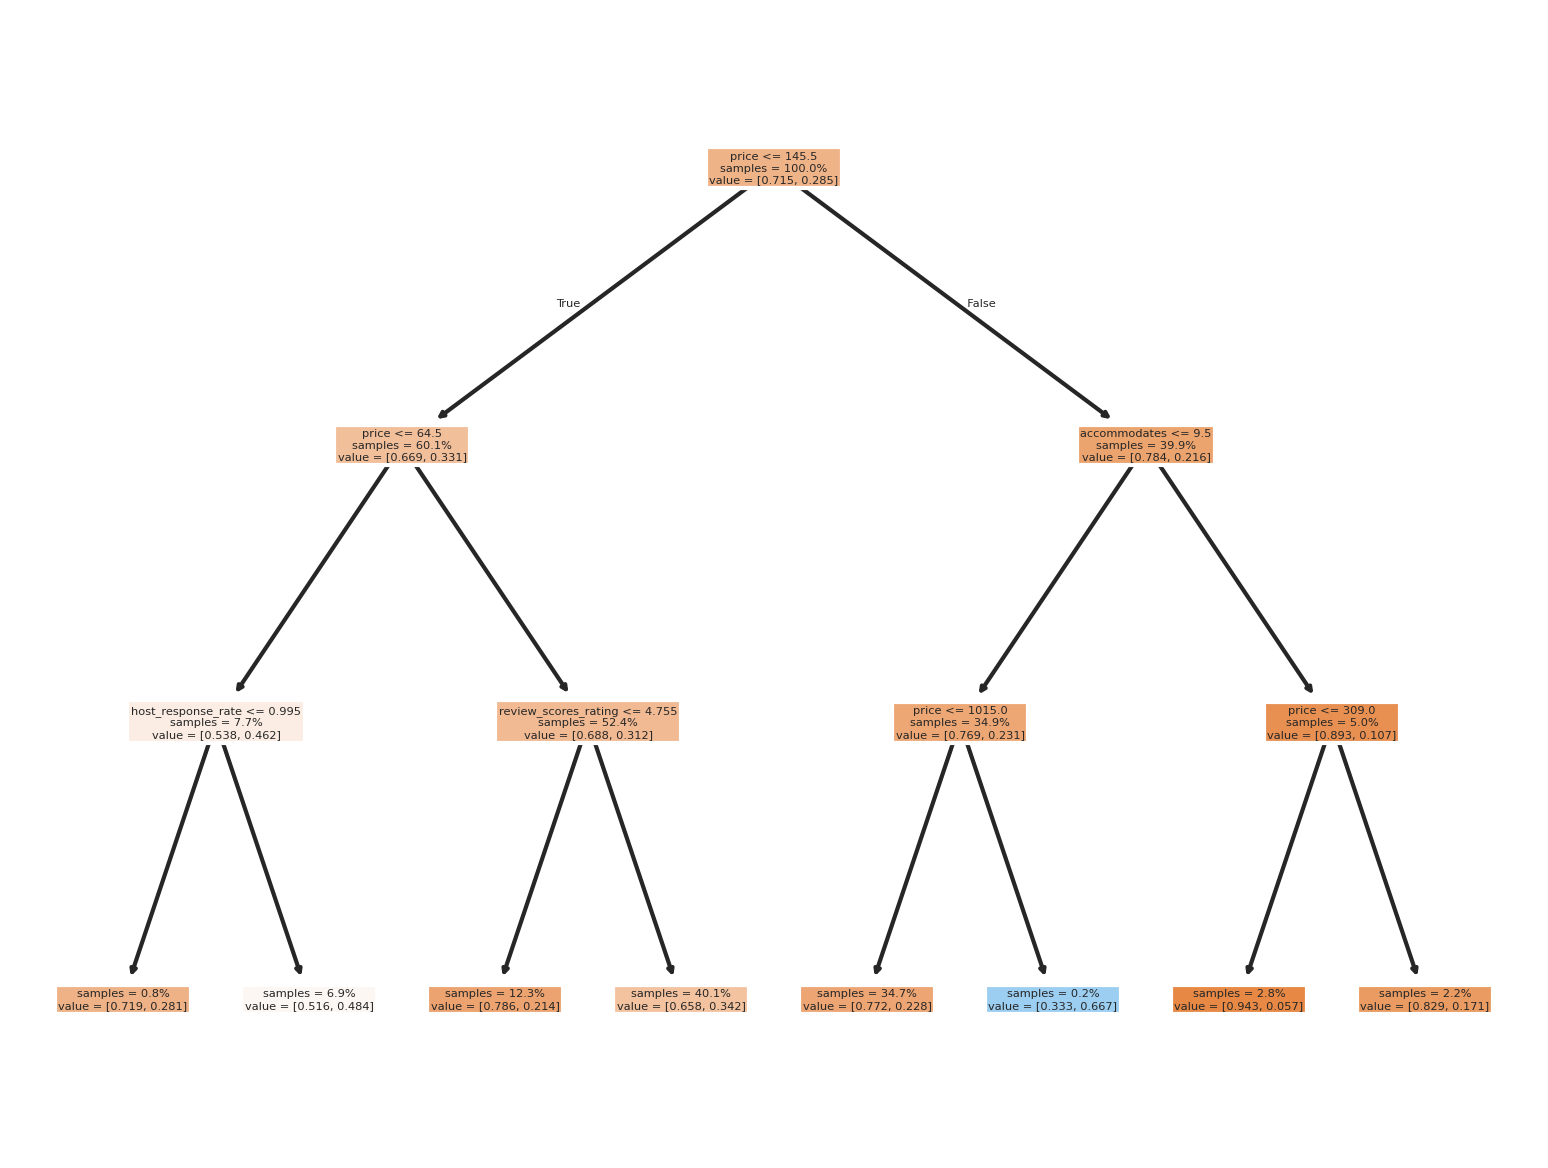

In [6]:
# 3. Given different factors, which Airbnbs are predicted to be popular?
def linear_svc(listings) -> float:
    """
    Use LinearSVC to determine whether availability_365 will be <= 92 (listing is popular) or
    > 92 (listing is not as popular). Find mse and accuracy
    """
    np.random.seed(42)

    listings_cleaned = listings.dropna(subset=["price", "accommodates"]).copy()
    listings_cleaned["popular"] = (listings_cleaned["availability_365"] <= 92).astype(int)

    X = listings_cleaned[["price", "accommodates"]]
    y = listings_cleaned["popular"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    clf = LinearSVC(max_iter=1000000, dual=False)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy of Model:", accuracy)

    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error:", mse)
    return mse

def decision_tree(listings) -> float:
    """
    Use decision tree regression to determine whether listing will be popular. Find mse and accuracy

    Interpreting the decision tree (more of a personal note): value[0] is the proportion of samples that are
    labeled not popular, and value[1] is the proportion that are labeled popular.
    """
    listings_cleaned = listings.dropna(subset=["price", "accommodates", "review_scores_rating", "host_response_rate"]).copy()
    listings_cleaned["popular"] = (listings_cleaned["availability_365"] <= 92).astype(int)
    listings_cleaned["host_response_rate"] = listings_cleaned["host_response_rate"].str.rstrip("%").astype(float) / 100

    np.random.seed(42)

    X = listings_cleaned[["price", "accommodates", "review_scores_rating", "host_response_rate"]]
    y = listings_cleaned["popular"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    tree_class = DecisionTreeClassifier(max_depth=3, random_state=42)
    tree_class.fit(X_train, y_train)
    accuracy = tree_class.score(X_test, y_test)

    # Visualize Decision Tree
    plt.figure(dpi=300)
    plot_tree(
        tree_class,
        feature_names=X.columns,
        filled=True,
        impurity=False,
        proportion=True,
        rounded=False,
        max_depth=3
    )

    print("Accuracy of Model:", accuracy)
    # check significance
    importances = tree_class.feature_importances_
    feature_names = X.columns
    for feature, importance in zip(feature_names, importances):
        print(feature, importance)

    y_pred = tree_class.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error:", mse)

    # I really don't need to return stuff, but I wanted to use it to practice different types of tests
    return mse

def random_forest(listings) -> float:
    """
    Use random forest to estimate which listings will be popular (available for <= than 1/4 the year). Find mse and accuracy
    """
    # drop na values, create popular column (available for <= 1/4 of year)
    listings_cleaned = listings.dropna(subset=["price", "accommodates"]).copy()
    listings_cleaned["popular"] = (listings_cleaned["availability_365"] <= 92).astype(int)

    np.random.seed(42)
    X = listings_cleaned[["price", "accommodates"]]
    y = listings_cleaned["popular"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)

    listings_cleaned = listings_cleaned.copy()
    listings_cleaned.loc[:, "predicted_popularity"] = clf.predict(X)

    popular_listings = listings_cleaned[listings_cleaned["predicted_popularity"] == 0]
    print(popular_listings["listing_url"])
    y_pred = clf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error:", mse)
    print("Accuracy of model:", accuracy)
    # check significance
    importances = clf.feature_importances_
    feature_names = X.columns
    for feature, importance in zip(feature_names, importances):
        print(feature, importance)
    return mse

# while I used three different machine learning methods, I only show Decision Tree classification
# because it was consistently the most accurate.
decision_tree(listings)

Mean bookings with Profile Picture: 176.26
Mean bookings without Profile Picture: 182.27
Median bookings with Profile Picture: 183.0
Median bookings without Profile Picture: 178.0


-6.0116215424956465

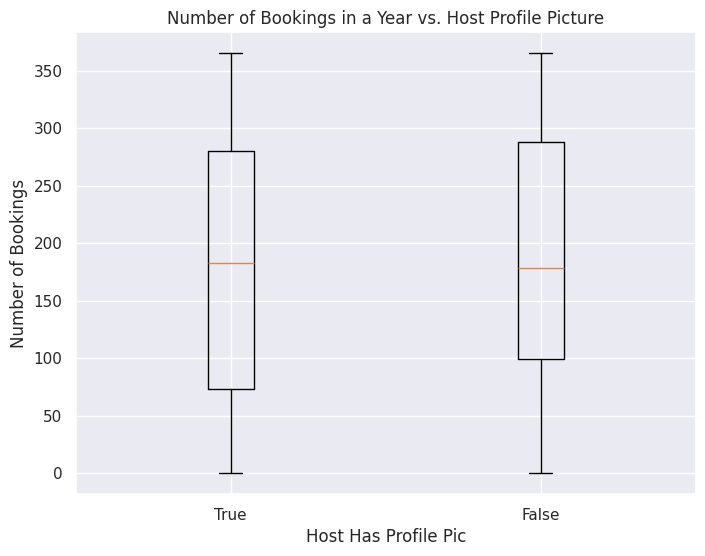

In [7]:
# 4. Does having a profile picture affect the popularity of a host's listing?
def pfp_bookings(listings):
    """
    Determines whether the host has a profile picture and the listing’s
    number of bookings in the next year to evaluate whether there is a correlation

    >>> pfp_bookings(listings_test)
    '-88.33333333333334'
    """
    listings["num_bookings"] = 365 - listings["availability_365"]

    true_data = listings[listings["host_has_profile_pic"] == "t"]["num_bookings"]
    false_data = listings[listings["host_has_profile_pic"] == "f"]["num_bookings"]

    plt.figure(figsize=(8, 6))
    plt.boxplot([true_data, false_data], labels=["True", "False"])
    plt.xlabel("Host Has Profile Pic")
    plt.ylabel("Number of Bookings")
    plt.title("Number of Bookings in a Year vs. Host Profile Picture")
    plt.grid(True)

    print("Mean bookings with Profile Picture:", round(true_data.mean(), 2))
    print("Mean bookings without Profile Picture:", round(false_data.mean(), 2))
    print("Median bookings with Profile Picture:", round(true_data.median(), 2))
    print("Median bookings without Profile Picture:", round(false_data.median(), 2))

    # Again, I know returned value is not used, but using it for doctest
    return (true_data.mean() - false_data.mean())

    plt.show()

pfp_bookings(listings)